In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class missile_interception_3d(gym.Env):
    def __init__(self):
        # 1. Define Action Space (The Joystick: Left/Right, Up/Down)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2, ), dtype=np.float32)
        
        # 2. Define Observation Space (20D ego-frame version)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)

        self.np_random = np.random.RandomState()
        
        # 3. Time Settings
        self.dt_act = 0.1             
        self.n_substeps = 10          
        self.dt_sim = self.dt_act / self.n_substeps 
        self.t_max = 650.0            

        # 4. Physical Limits
        self.a_max = 350.0   # Max G-force (m/s^2) ~35G
        self.da_max = 2500.0 # Jerk Limit (m/s^3)
        self.tau = 0.05      # Airframe Lag
        self.g = 9.81        
        self.collision_radius = 150.0  
        self.max_distance = 4_000_000.0 

        self.p_easy = 1.0                   
        self.range_min = 70_000.0           
        self.range_easy_max = 200_000.0     
        self.range_hard_max = 1_000_000.0   

        self.targetbox_x_min = -15000
        self.targetbox_x_max = 15000
        self.targetbox_y_min = -15000
        self.targetbox_y_max = 15000

        # ----------------------------
        # Potential-based shaping (ZEM_perp)
        # IMPORTANT: gamma_shape MUST match PPO's gamma
        # ----------------------------
        self.gamma_shape = 0.9999      # set to your PPO gamma
        self.w_zem = 1.0             # shaping weight
        self.zem_scale = 50_000.0    # meters; tunes magnitude of phi
        self.tgo_max = 15.0          # seconds; clamp lookahead when closing
        self.tgo_fixed = 3.0         # seconds; lookahead when NOT closing
        self.vc_min = 1.0            # m/s; treat <= this as "not closing"

    def generate_enemy_missile(self):
        if self.np_random.rand() < self.p_easy:
            self.range_max_used = self.range_easy_max
        else:
            self.range_max_used = self.range_hard_max

        range_min = self.range_min
        self.attack_target_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.attack_target_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)
        self.enemy_launch_angle = self.np_random.uniform(0, 2 * np.pi)
        self.enemy_theta = self.np_random.uniform(0.523599, 1.0472) 

        self.range_max_used = max(self.range_max_used, range_min + 1.0)
        lower_limit = np.sqrt((range_min * self.g) / np.sin(2 * self.enemy_theta))
        upper_limit = np.sqrt((self.range_max_used * self.g) / np.sin(2 * self.enemy_theta))
        self.enemy_initial_velocity = self.np_random.uniform(lower_limit, upper_limit)

        ground_range = (
            self.enemy_initial_velocity * np.cos(self.enemy_theta)
            * (2 * self.enemy_initial_velocity * np.sin(self.enemy_theta) / self.g)
        )

        self.enemy_launch_x = self.attack_target_x + ground_range * np.cos(self.enemy_launch_angle)
        self.enemy_launch_y = self.attack_target_y + ground_range * np.sin(self.enemy_launch_angle)
        self.enemy_z = 0
        self.enemy_x = self.enemy_launch_x
        self.enemy_y = self.enemy_launch_y
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_azimuth = (self.enemy_launch_angle + np.pi) % (2 * np.pi)

    def generate_defense_missile(self):
        self.defense_launch_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.defense_launch_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)

        dx = self.enemy_launch_x - self.defense_launch_x
        dy = self.enemy_launch_y - self.defense_launch_y
        az_nominal = np.arctan2(dy, dx)

        # --- Misalignment (domain randomization of initial heading) ---
        # Mixture: most episodes small error, some episodes large az error
        p_misaligned = 0.35  # 35% "hard" starts
        if self.np_random.rand() < p_misaligned:
            # Hard: big azimuth error → strong RIGHT required
            az_noise = self.np_random.uniform(-np.deg2rad(60.0), np.deg2rad(60.0))
        else:
            # Easy: small azimuth error → gentle correction
            az_noise = self.np_random.uniform(-np.deg2rad(10.0), np.deg2rad(10.0))

        self.defense_azimuth = az_nominal + az_noise

        # Elevation noise: avoid always same vertical plane
        theta_nominal = 0.785398  # ~45 deg
        theta_noise_deg = 10.0
        theta_noise = self.np_random.uniform(
            -np.deg2rad(theta_noise_deg),
            +np.deg2rad(theta_noise_deg),
        )
        self.defense_theta = float(np.clip(theta_nominal + theta_noise,
                                           np.deg2rad(10.0),
                                           np.deg2rad(80.0)))
        # ---------------------------------------------------------------

        base_velocity = 3000.0
        if hasattr(self, 'range_max_used'):
            velocity_scale = min(self.range_max_used / self.range_easy_max, 1.5)
            self.defense_initial_velocity = base_velocity * velocity_scale
        else:
            self.defense_initial_velocity = base_velocity

        self.defense_x = self.defense_launch_x
        self.defense_y = self.defense_launch_y
        self.defense_z = 0.0
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)

        self.defense_ax = 0.0
        self.defense_ay = 0.0
        self.defense_az = 0.0
    
    def _smoothstep(self, x: float) -> float:
        """Smooth ramp 0->1 with zero slope at ends, clamps outside [0,1]"""
        x = float(np.clip(x, 0.0, 1.0))
        return x * x * (3.0 - 2.0 * x)
    
    def calculate_pronav(self):
        eps = 1e-9

        # Relative geometry (use float64 for stability)
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        v = self.defense_vel.astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        V = float(np.linalg.norm(v)) + eps

        rhat = r / R
        vhat = v / V

        # Heading error alpha = angle between velocity direction and LOS direction
        cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
        alpha = float(np.arccos(cosang))  # radians

        # LOS angular rate omega (world frame)
        omega = np.cross(r, vrel) / (float(np.dot(r, r)) + eps)
        omega_mag = float(np.linalg.norm(omega))

        # Closing speed (positive => closing)
        vc = -float(np.dot(r, vrel)) / R

        # --- PN term ---
        N = 3.0
        a_pn = N * vc * np.cross(omega, rhat)  # lateral accel in world frame

        # --- Acquisition term (turn-to-LOS) ---
        # Perpendicular component of LOS relative to forward direction
        rhat_perp = rhat - float(np.dot(rhat, vhat)) * vhat
        nperp = float(np.linalg.norm(rhat_perp))

        if nperp < 1e-8:
            a_acq = np.zeros(3, dtype=np.float64)
        else:
            rhat_perp /= nperp  # unit sideways "turn toward LOS" direction

            # Curvature-based magnitude: ~k * V^2 / R, saturate later via a_max
            k_acq = 5.0  # try 3.0–8.0
            a_acq = k_acq * (V * V / R) * rhat_perp

        # --- Blend weight w: 0 => pure PN, 1 => pure acquisition ---

        # Alpha-based weight (dominant)
        alpha_on   = np.deg2rad(20.0)   # start blending earlier
        alpha_full = np.deg2rad(55.0)

        x_alpha = (alpha - alpha_on) / (alpha_full - alpha_on + eps)
        w_alpha = self._smoothstep(x_alpha)

        # Omega-based modifier (only boosts acquisition when PN is sleepy)
        omega_full = 0.00
        omega_on   = 0.05   # <-- key: less brittle than 0.02

        x_omega = (omega_on - omega_mag) / (omega_on - omega_full + eps)
        w_omega = self._smoothstep(x_omega)

        # Robust combine: alpha dominates; omega can't fully shut it off
        w = w_alpha * (0.25 + 0.75 * w_omega)

        # Optional: if not closing, force strong acquisition
        if vc <= 0.0:
            w = max(w, 0.9)

        a_ideal = (1.0 - w) * a_pn + w * a_acq

        # Project into your lateral control basis (right/up) and normalize by a_max
        # Note: Environment now handles gravity compensation internally,
        # so ProNav outputs desired NET lateral accel (same semantics as PPO)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)
        a_right = float(np.dot(a_ideal, right))
        a_up    = float(np.dot(a_ideal, up))

        action = np.array([a_right / self.a_max, a_up / self.a_max], dtype=np.float32)
        return np.clip(action, -1.0, 1.0)
    
    def _rate_limit_norm(self, a_cmd, a_prev, da_max, dt):
        delta = a_cmd - a_prev
        max_delta = da_max * dt
        dnorm = float(np.linalg.norm(delta))
        if dnorm <= max_delta or dnorm < 1e-9:
            return a_cmd
        return a_prev + delta * (max_delta / dnorm)
    
    def _segment_sphere_intersect(self, r0, r1, r_hit):
        dr = r1 - r0
        dr_norm_sq = float(np.dot(dr, dr))
        if dr_norm_sq < 1e-12:
            return float(np.dot(r0, r0)) <= r_hit * r_hit
        s_star = -float(np.dot(r0, dr)) / dr_norm_sq
        s_star = max(0.0, min(1.0, s_star))
        r_closest = r0 + s_star * dr
        return float(np.dot(r_closest, r_closest)) <= r_hit * r_hit
    
    def _phi_zem_perp(self):
        """
        Potential for potential-based shaping:
          Phi(s) = - ||ZEM_perp|| / zem_scale

        Returns:
          phi, zem_perp_norm, Vc, tgo
        """
        eps = 1e-9

        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        rhat = r / R

        # Closing speed (positive = closing)
        Vc = -float(np.dot(rhat, vrel))

        if Vc > self.vc_min:
            tgo = R / max(Vc, eps)
            tgo = float(np.clip(tgo, 0.0, self.tgo_max))
        else:
            tgo = float(self.tgo_fixed)

        zem = r + vrel * tgo
        zem_perp = zem - float(np.dot(zem, rhat)) * rhat
        zem_perp_norm = float(np.linalg.norm(zem_perp))

        phi = -zem_perp_norm / (float(self.zem_scale) + eps)
        return float(phi), zem_perp_norm, float(Vc), tgo
    
    
    def _get_obs(self):
        eps = 1e-9

        # World-frame relative state
        r_world = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel_world = (self.enemy_vel - self.defense_vel).astype(np.float64)

        # Local basis from defense velocity (world frame unit vectors)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)

        # ===============================
        # 1) Ego-frame (body-frame) r and vrel
        # ===============================
        r_body = np.array([
            float(np.dot(r_world, forward)),
            float(np.dot(r_world, right)),
            float(np.dot(r_world, up)),
        ], dtype=np.float64)

        vrel_body = np.array([
            float(np.dot(vrel_world, forward)),
            float(np.dot(vrel_world, right)),
            float(np.dot(vrel_world, up)),
        ], dtype=np.float64)

        # Normalize r_body / vrel_body (keep your original scaling)
        pos_scale = float(self.range_hard_max)   # 1_000_000
        vel_scale = 4000.0

        r_body_n = (r_body / (pos_scale + eps)).astype(np.float32)
        vrel_body_n = (vrel_body / (vel_scale + eps)).astype(np.float32)

        # ===============================
        # 2) Actuator state in the same action frame
        # ===============================
        a_lat = np.array([
            float(np.dot(self.a_actual, right)) / (self.a_max + eps),
            float(np.dot(self.a_actual, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # NEW: hidden actuator state that affects transitions
        a_cmd_prev_lat = np.array([
            float(np.dot(self.a_cmd_prev, right)) / (self.a_max + eps),
            float(np.dot(self.a_cmd_prev, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # ===============================
        # 3) Scalar helpers (kept)
        # ===============================
        dist = float(np.linalg.norm(r_world)) + 1e-6
        v_close = -float(np.dot(r_world, vrel_world)) / dist  # positive when closing

        dist_n = np.float32(np.clip(dist / 1_000_000.0, 0.0, 4.0))
        vclose_n = np.float32(np.clip(v_close / 3000.0, -2.0, 2.0))
        dist_vclose_feat = np.array([dist_n, vclose_n], dtype=np.float32)

        # Defense own vertical state (keep for ground constraint)
        def_z_n = np.float32(np.clip(self.defense_pos[2] / 100_000.0, -1.0, 2.0))
        def_vz_n = np.float32(np.clip(self.defense_vel[2] / 3000.0, -2.0, 2.0))
        def_state_feat = np.array([def_z_n, def_vz_n], dtype=np.float32)

        # ===============================
        # 4) Keep your geometry features (consistent with ego-frame)
        # ===============================
        dist_body = float(np.linalg.norm(r_body)) + 1e-6

        # LOS lateral projections in body frame
        los_right = float(r_body[1] / dist_body)
        los_up    = float(r_body[2] / dist_body)

        # LOS rate omega in body frame: omega = (r x vrel)/||r||^2
        dist2_body = float(np.dot(r_body, r_body)) + eps
        omega_body = np.cross(r_body, vrel_body) / dist2_body

        omega_right = float(omega_body[1])
        omega_up    = float(omega_body[2])

        omega_scale = 2.0
        omega_right_n = float(np.clip(omega_right / omega_scale, -2.0, 2.0))
        omega_up_n    = float(np.clip(omega_up / omega_scale, -2.0, 2.0))

        geom_feat = np.array([los_right, los_up, omega_right_n, omega_up_n], dtype=np.float32)

        # ===============================
        # 5) NEW: kinematics garnish
        # ===============================
        V_def = float(np.linalg.norm(self.defense_vel))
        V_def_n = np.float32(np.clip(V_def / 3000.0, 0.0, 3.0))  # scale: 3000 m/s baseline
        forward_z = np.float32(float(forward[2]))               # dot(forward, world_up) since world_up=[0,0,1]

        kin_feat = np.array([V_def_n, forward_z], dtype=np.float32)

        # Final obs (20D)
        obs = np.concatenate(
            [r_body_n, vrel_body_n, a_lat, a_cmd_prev_lat, dist_vclose_feat, def_state_feat, geom_feat, kin_feat],
            axis=0
        ).astype(np.float32)

        # Optional sanity check while iterating
        # assert obs.shape == (20,), obs.shape

        return obs

    def _compute_lateral_basis(self, velocity):
        """
        Horizon-stable basis:
          forward = along velocity
          right   = world_up x forward  (horizontal right)
          up      = forward x right     (completes orthonormal frame)
        This keeps 'up' as close to world-up as possible and avoids weird twisting.
        """
        speed = float(np.linalg.norm(velocity))
        if speed < 1.0:
            forward = np.array([1.0, 0.0, 0.0], dtype=np.float32)
        else:
            forward = (velocity / speed).astype(np.float32)

        world_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)

        # right = world_up x forward
        right_raw = np.cross(world_up, forward)
        rnorm = float(np.linalg.norm(right_raw))

        # If forward is near world_up, right_raw ~ 0. Pick a consistent fallback.
        if rnorm < 1e-6:
            # Choose a fixed "north" axis in world XY and build right from that
            # This prevents random spinning when vertical.
            north = np.array([1.0, 0.0, 0.0], dtype=np.float32)
            right_raw = np.cross(north, forward)
            rnorm = float(np.linalg.norm(right_raw))
            if rnorm < 1e-6:
                north = np.array([0.0, 1.0, 0.0], dtype=np.float32)
                right_raw = np.cross(north, forward)
                rnorm = float(np.linalg.norm(right_raw))

        right = (right_raw / (rnorm + 1e-9)).astype(np.float32)

        # up = forward x right (not right x forward)
        up_raw = np.cross(forward, right)
        up = (up_raw / (float(np.linalg.norm(up_raw)) + 1e-9)).astype(np.float32)

        return forward, right, up

    def step(self, action):
        if getattr(self, "done", False):
            return self._get_obs(), 0.0, True, False, {"event": "called_step_after_done", "dist": self.relative_distances[-1]}
        
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        mag = float(np.linalg.norm(action))
        if mag > 1.0:
            action = action / mag
            mag = 1.0
        
        # Update episode trackers
        self.ep_max_action_mag = max(self.ep_max_action_mag, float(mag))
        self.ep_max_accel = max(self.ep_max_accel, float(np.linalg.norm(self.a_actual)))

        dist_before = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        
        # --- Shaping: compute phi BEFORE transition ---
        phi_before, zem_perp_before, Vc_before, tgo_before = self._phi_zem_perp()
        terminated = False
        truncated = False
        event = "running"
        
        for _ in range(self.n_substeps):
            dt = self.dt_sim
            enemy_pos_old = self.enemy_pos.copy()
            defense_pos_old = self.defense_pos.copy()
            
            forward, right, up = self._compute_lateral_basis(self.defense_vel)
            
            # Agent command = desired NET lateral accel (world frame)
            a_net_lat_cmd = (action[0] * self.a_max * right) + (action[1] * self.a_max * up)
            
            # Gravity (world frame)
            g_vec = np.array([0.0, 0.0, -self.g], dtype=np.float32)
            
            # Lateral component of gravity in the right/up plane
            g_lat = (np.dot(g_vec, right) * right) + (np.dot(g_vec, up) * up)
            
            # Fins must cancel lateral gravity to achieve commanded NET lateral accel
            a_fins_cmd = a_net_lat_cmd - g_lat
            
            # Apply rate limit + lag to fins acceleration
            self.a_cmd_prev = self._rate_limit_norm(a_fins_cmd, self.a_cmd_prev, self.da_max, dt)
            self.a_actual += (self.a_cmd_prev - self.a_actual) * (dt / self.tau)
            
            # Integrate translational dynamics
            self.defense_vel += (self.a_actual + g_vec) * dt
            self.defense_pos += self.defense_vel * dt
            self.defense_x, self.defense_y, self.defense_z = self.defense_pos
            
            # Enemy missile: pure ballistic (gravity only)
            self.enemy_vel += g_vec * dt
            self.enemy_pos += self.enemy_vel * dt
            self.enemy_x, self.enemy_y, self.enemy_z = self.enemy_pos
            self.t += dt
            
            r0 = enemy_pos_old - defense_pos_old
            r1 = self.enemy_pos - self.defense_pos
            if self._segment_sphere_intersect(r0, r1, self.collision_radius):
                self.success = True
                terminated = True
                self.done = True
                event = "hit"
                self.time_to_hit = float(self.t)
                self.terminal_event = "hit"
                break
            
            dist = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
            if dist > self.max_distance:
                truncated = True
                self.done = True
                event = "diverged"
                self.terminal_event = "diverged"
                break
            if self.defense_pos[2] < 0:
                terminated = True
                self.done = True
                event = "defense_ground"
                self.terminal_event = "defense_ground"
                break
            if self.enemy_pos[2] < 0:
                terminated = True
                self.done = True
                event = "enemy_ground"
                self.terminal_event = "enemy_ground"
                break
            if self.t >= self.t_max:
                truncated = True
                self.done = True
                event = "timeout"
                self.terminal_event = "timeout"
                break

        self.enemy_path.append(self.enemy_pos.copy())
        self.defense_path.append(self.defense_pos.copy())
        self.relative_distances.append(float(np.linalg.norm(self.enemy_pos - self.defense_pos)))
        self.times.append(self.t)
        
        obs = self._get_obs()
        dist_after = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        self.min_dist = min(getattr(self, "min_dist", float("inf")), dist_after)
        self.ep_min_dist = min(self.ep_min_dist, float(dist_after))
        
        # Reward calculation (same as before)
        r_progress = (dist_before - dist_after) / 100.0
        v_scale = 1500.0
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)
        d = float(np.linalg.norm(r)) + 1e-9
        rhat = r / d
        d_dot = float(np.dot(rhat, vrel))
        r_close = np.tanh((-d_dot) / v_scale)
        
        # --- Shaping: compute phi AFTER transition ---
        if terminated or truncated:
            # standard trick for episodic shaping: set terminal potential to 0
            phi_after = 0.0
            zem_perp_after = None
            Vc_after = None
            tgo_after = None
        else:
            phi_after, zem_perp_after, Vc_after, tgo_after = self._phi_zem_perp()

        r_zem = self.w_zem * (self.gamma_shape * phi_after - phi_before)
        
        # Accumulate shaping rewards for debugging
        self.sum_r_progress += float(r_progress)
        self.sum_r_close += float(r_close)
        self.sum_r_zem += float(r_zem)
        
        # Reward breakdown (named components)
        step_penalty = -0.001
        terminal_bonus = 0.0
        terminal_penalty = 0.0
        
        if self.success:
            terminal_bonus = 10000.0
        elif terminated or truncated:
            if event == "defense_ground":
                terminal_penalty += 10000.0
            terminal_penalty += min(2000.0, self.ep_min_dist / 50.0)
        
        reward = (1.0 * r_progress) + (0.1 * r_close) + step_penalty + terminal_bonus - terminal_penalty + r_zem
        
        info = {
            "event": event,
            "t": float(self.t),
            
            # reward pieces (training-related)
            "reward_terms": {
                "r_progress": float(r_progress),
                "r_close": float(r_close),
                "step_penalty": float(step_penalty),
                "terminal_bonus": float(terminal_bonus),
                "terminal_penalty": float(-terminal_penalty),  # negative contribution
                "r_zem": float(r_zem),
            },
            "reward": float(reward),
            
            # ZEM shaping debug info
            "zem_debug": {
                "phi_before": float(phi_before),
                "phi_after": float(phi_after),
                "zem_perp_before": float(zem_perp_before),
                "zem_perp_after": None if zem_perp_after is None else float(zem_perp_after),
                "Vc_before": float(Vc_before),
                "Vc_after": None if Vc_after is None else float(Vc_after),
                "tgo_before": float(tgo_before),
                "tgo_after": None if tgo_after is None else float(tgo_after),
            },
            
            # eval snapshots (NOT the full episode metrics yet)
            "eval_step": {
                "dist": float(dist_after),
                "action_mag": float(mag),
                "accel_norm": float(np.linalg.norm(self.a_actual)),
            },
        }
        return obs, reward, terminated, truncated, info


    def _snapshot(self):
        """Copy everything that affects future transitions + trackers used by reward."""
        return {
            "t": float(self.t),
            "enemy_pos": self.enemy_pos.copy(),
            "enemy_vel": self.enemy_vel.copy(),
            "defense_pos": self.defense_pos.copy(),
            "defense_vel": self.defense_vel.copy(),
            "a_actual": self.a_actual.copy(),
            "a_cmd_prev": self.a_cmd_prev.copy(),
            "done": bool(getattr(self, "done", False)),
            "success": bool(getattr(self, "success", False)),

            # reward-critical trackers
            "min_dist": float(getattr(self, "min_dist", float("inf"))),
            "ep_min_dist": float(getattr(self, "ep_min_dist", float("inf"))),

            # episode trackers (not strictly needed for the local test but cheap)
            "ep_max_action_mag": float(getattr(self, "ep_max_action_mag", 0.0)),
            "ep_max_accel": float(getattr(self, "ep_max_accel", 0.0)),
            "time_to_hit": getattr(self, "time_to_hit", None),
            "terminal_event": getattr(self, "terminal_event", "running"),

            # log lengths (so restore can truncate)
            "enemy_path_len": len(getattr(self, "enemy_path", [])),
            "defense_path_len": len(getattr(self, "defense_path", [])),
            "relative_distances_len": len(getattr(self, "relative_distances", [])),
            "times_len": len(getattr(self, "times", [])),
        }

    def _restore(self, snap):
        """Restore environment state from snapshot."""
        self.t = float(snap["t"])
        self.enemy_pos = snap["enemy_pos"].copy()
        self.enemy_vel = snap["enemy_vel"].copy()
        self.defense_pos = snap["defense_pos"].copy()
        self.defense_vel = snap["defense_vel"].copy()
        self.a_actual = snap["a_actual"].copy()
        self.a_cmd_prev = snap["a_cmd_prev"].copy()
        self.done = bool(snap["done"])
        self.success = bool(snap["success"])

        self.min_dist = float(snap["min_dist"])
        self.ep_min_dist = float(snap["ep_min_dist"])

        self.ep_max_action_mag = float(snap["ep_max_action_mag"])
        self.ep_max_accel = float(snap["ep_max_accel"])
        self.time_to_hit = snap["time_to_hit"]
        self.terminal_event = snap["terminal_event"]

        # truncate logs (avoid memory blow + keep things consistent)
        if hasattr(self, "enemy_path"):
            self.enemy_path = self.enemy_path[: snap["enemy_path_len"]]
        if hasattr(self, "defense_path"):
            self.defense_path = self.defense_path[: snap["defense_path_len"]]
        if hasattr(self, "relative_distances"):
            self.relative_distances = self.relative_distances[: snap["relative_distances_len"]]
        if hasattr(self, "times"):
            self.times = self.times[: snap["times_len"]]


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None: self.np_random = np.random.RandomState(seed)
        self.done = False
        self.success = False
        self.t = 0.0
        self.generate_enemy_missile()
        self.generate_defense_missile()
        
        self.defense_vel = np.array([
            self.defense_initial_velocity * np.cos(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_theta)
        ], dtype=np.float32)
        
        self.enemy_vel = np.array([
            self.enemy_initial_velocity * np.cos(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_theta)
        ], dtype=np.float32)
        
        self.a_actual = np.zeros(3, dtype=np.float32)
        self.a_cmd_prev = np.zeros(3, dtype=np.float32)
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_path = [self.enemy_pos.copy()]
        self.defense_path = [self.defense_pos.copy()]
        self.relative_distances = [float(np.linalg.norm(self.enemy_pos - self.defense_pos))]
        self.times = [self.t]
        self.min_dist = float(self.relative_distances[-1])
        self.sum_r_progress = 0.0
        self.sum_r_close = 0.0
        self.sum_r_zem = 0.0
        
        # --- episode eval trackers (NOT used in reward) ---
        self.ep_min_dist = float("inf")
        self.ep_max_action_mag = 0.0
        self.ep_max_accel = 0.0          # optional: actual accel norm
        self.time_to_hit = None
        self.terminal_event = "running"
        
        return self._get_obs(), {}


# ==========================================
# EVALUATION FUNCTION (separate from training reward)
# ==========================================
def evaluate_policy(env, policy_fn, n_episodes=100, seed0=0):
    """
    Evaluate a policy and return episode-level metrics.
    This is separate from training reward - these metrics are what you actually care about.
    
    Args:
        env: missile_interception_3d environment instance
        policy_fn: Function that takes obs and returns action
        n_episodes: Number of episodes to evaluate
        seed0: Starting seed (episodes use seed0, seed0+1, ..., seed0+n_episodes-1)
    
    Returns:
        summary: Dict with aggregated metrics (hit_rate, min_dist stats, etc.)
        metrics: Dict with raw episode data
    """
    metrics = {
        "hits": 0,
        "ground_defense": 0,
        "ground_enemy": 0,
        "diverged": 0,
        "timeout": 0,
        "min_dist_list": [],
        "time_to_hit_list": [],
        "max_g_list": [],
    }

    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + i)
        done = False

        while not done:
            action = policy_fn(obs)  # your PPO policy OR env.calculate_pronav() baseline
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        event = info["event"]
        metrics["min_dist_list"].append(env.ep_min_dist)
        metrics["max_g_list"].append(env.ep_max_action_mag)

        if event == "hit":
            metrics["hits"] += 1
            if env.time_to_hit is not None:
                metrics["time_to_hit_list"].append(env.time_to_hit)
        elif event == "defense_ground":
            metrics["ground_defense"] += 1
        elif event == "enemy_ground":
            metrics["ground_enemy"] += 1
        elif event == "diverged":
            metrics["diverged"] += 1
        elif event == "timeout":
            metrics["timeout"] += 1

    hit_rate = metrics["hits"] / n_episodes

    summary = {
        "hit_rate": hit_rate,
        "min_dist_mean": float(np.mean(metrics["min_dist_list"])),
        "min_dist_p50": float(np.median(metrics["min_dist_list"])),
        "min_dist_p10": float(np.percentile(metrics["min_dist_list"], 10)),
        "time_to_hit_mean": float(np.mean(metrics["time_to_hit_list"])) if metrics["time_to_hit_list"] else None,
        "max_g_mean": float(np.mean(metrics["max_g_list"])),
        "violations": {
            "defense_ground": metrics["ground_defense"],
            "enemy_ground": metrics["ground_enemy"],
            "diverged": metrics["diverged"],
            "timeout": metrics["timeout"],
        }
    }
    return summary, metrics


# ==========================================
# TEST PRONAV BASELINE (No Animation)
# ==========================================

# def run_baseline():
#     env = missile_interception_3d()
#     outcomes = []
#     min_distances = []
#     action_loads = [] # Track if we are saturating (maxing out fins)

#     N_EPISODES = 50
#     print(f"Running {N_EPISODES} episodes of Augmented ProNav...")

#     for i in range(N_EPISODES):
#         obs, _ = env.reset(seed=i)
#         done = False
#         ep_actions = []

#         while not done:
#             # 1. Ask ProNav for the move
#             action = env.calculate_pronav()
            
#             # 2. Track how hard it's pushing (0.0 to 1.0)
#             mag = np.linalg.norm(action)
#             ep_actions.append(mag)

#             obs, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated
        
#         outcomes.append(info['event'])
#         min_distances.append(info['min_dist'])
#         avg_load = np.mean(ep_actions)
#         action_loads.append(avg_load)

#         print(f"Ep {i+1:02d} | Res: {info['event']:<14} | Min Dist: {info['min_dist']:.1f} m | Avg G-Load: {avg_load*100:.1f}%")

#     # Final Stats
#     hits = outcomes.count("hit")
#     print("\n--- SUMMARY ---")
#     print(f"Hit Rate: {hits}/{N_EPISODES} ({hits/N_EPISODES*100:.1f}%)")
#     print(f"Average Miss Distance (Non-hits): {np.mean([d for d, e in zip(min_distances, outcomes) if e != 'hit']):.2f} m")
#     print(f"Average G-Loading: {np.mean(action_loads)*100:.1f}% (If >90%, missile is physically too weak)")

# if __name__ == "__main__":
#     run_baseline()

Using cpu device
Logging to ./tb_missile/PPO_12
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.66e+03  |
|    ep_rew_mean     | -4.25e+03 |
| time/              |           |
|    fps             | 188       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.31e+03    |
|    ep_rew_mean          | -3.53e+03   |
| time/                   |             |
|    fps                  | 233         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006187904 |
|    clip_fraction        | 0.0201      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained

NameError: name 'animation' is not defined

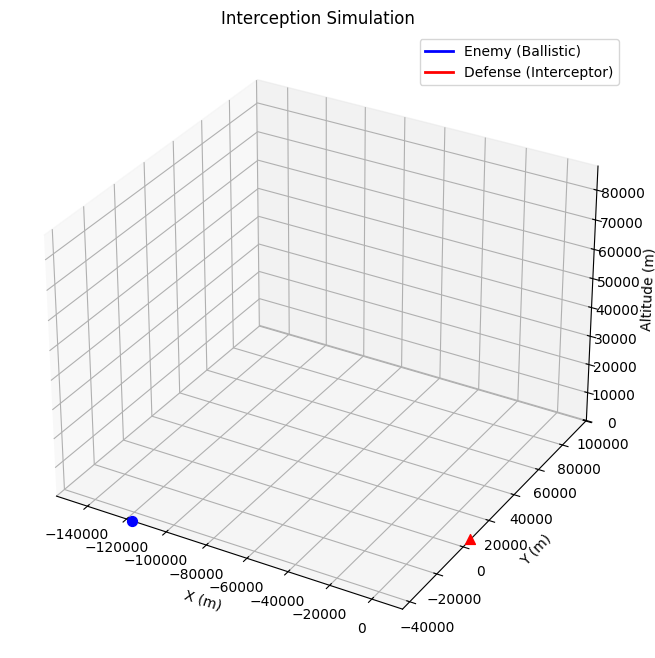

In [11]:
import os, csv
import numpy as np
from collections import deque, Counter

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# ==========================================
# YOUR ANIMATION FUNCTIONS (must be in scope)
# ==========================================
def update_paths(num, xe, ye, ze, xd, yd, zd, lines, ax):
    lines[0].set_data_3d(xe[:num], ye[:num], ze[:num])
    lines[1].set_data_3d(xd[:num], yd[:num], zd[:num])
    ax.view_init(elev=20, azim=-60 + (num * 0.2))
    return lines

def animate_trajectories(enemy_path, defense_path):
    enemy_path_array = np.array(enemy_path)
    defense_path_array = np.array(defense_path)

    xe, ye, ze = enemy_path_array[:, 0], enemy_path_array[:, 1], enemy_path_array[:, 2]
    xd, yd, zd = defense_path_array[:, 0], defense_path_array[:, 1], defense_path_array[:, 2]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    all_x = np.concatenate((xe, xd))
    all_y = np.concatenate((ye, yd))
    all_z = np.concatenate((ze, zd))

    # avoid identical min/max which can crash set_xlim
    eps = 1e-6
    ax.set_xlim([np.min(all_x) - eps, np.max(all_x) + eps])
    ax.set_ylim([np.min(all_y) - eps, np.max(all_y) + eps])
    ax.set_zlim([0, max(eps, np.max(all_z) + eps)])

    line_enemy, = ax.plot([], [], [], 'b-', linewidth=2, label="Enemy (Ballistic)")
    line_defense, = ax.plot([], [], [], 'r-', linewidth=2, label="Defense (Interceptor)")

    ax.scatter(xe[0], ye[0], ze[0], color='blue', s=50, marker='o')
    ax.scatter(xd[0], yd[0], zd[0], color='red', s=50, marker='^')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Altitude (m)')
    ax.set_title('Interception Simulation')
    ax.legend()

    total_steps = len(xe)
    step_size = max(1, total_steps // 200)
    frames = range(0, total_steps, step_size)

    ani = animation.FuncAnimation(
        fig,
        update_paths,
        frames=len(frames),
        fargs=(xe[::step_size], ye[::step_size], ze[::step_size],
               xd[::step_size], yd[::step_size], zd[::step_size],
               [line_enemy, line_defense], ax),
        interval=30,
        blit=False
    )

    plt.close(fig)
    return HTML(ani.to_html5_video())



# ==========================================
# SB3 env factory (NO VecMonitor encima)
# ==========================================
def make_env(seed=0):
    def _init():
        env = missile_interception_3d()
        env = Monitor(env)          # esto mete info["episode"] al final del episodio
        env.reset(seed=seed)
        return env
    return _init

# Helper: obtener el env real (unwrapped) desde VecEnv
def get_unwrapped_env(vec_env, idx=0):
    # DummyVecEnv mantiene .envs
    e = vec_env.envs[idx]
    # Monitor env -> unwrapped vuelve al env base
    return e.unwrapped

# ==========================================
# CSV Logger Callback (robusto a tu env real)
# ==========================================
class CSVLoggerPlusCallback(BaseCallback):
    def __init__(
        self,
        csv_path: str = "./logs/train_plus.csv",
        flush_every_episodes: int = 10,
        verbose: int = 0,
    ):
        super().__init__(verbose)
        self.csv_path = csv_path
        self.flush_every_episodes = int(flush_every_episodes)

        self._rows = []
        self._episode_count = 0

        self._fieldnames = [
            "timesteps", "episode_idx",
            "ep_reward", "ep_len",
            "event", "final_dist", "min_dist",
            "sum_r_progress", "sum_r_close", "sum_r_zem",
            # PPO health (si existe en el logger en ese instante)
            "approx_kl", "clip_fraction", "entropy_loss", "explained_variance",
            "value_loss", "policy_gradient_loss",
            # Física simple (desde el env)
            "max_action_mag", "max_accel_norm", "time_to_hit",
        ]

    def _ensure_dir(self):
        d = os.path.dirname(self.csv_path)
        if d:
            os.makedirs(d, exist_ok=True)

    def _write_header_if_needed(self):
        if (not os.path.exists(self.csv_path)) or os.path.getsize(self.csv_path) == 0:
            with open(self.csv_path, "w", newline="") as f:
                csv.DictWriter(f, fieldnames=self._fieldnames).writeheader()

    def _flush(self):
        if not self._rows:
            return
        self._ensure_dir()
        self._write_header_if_needed()
        with open(self.csv_path, "a", newline="") as f:
            csv.DictWriter(f, fieldnames=self._fieldnames).writerows(self._rows)
        self._rows.clear()

    def _get_ppo_scalars(self):
        # SB3 guarda scalars en model.logger.name_to_value (no siempre están)
        lg = getattr(self.model, "logger", None)
        name_to_value = getattr(lg, "name_to_value", {}) if lg is not None else {}

        def get(key):
            v = name_to_value.get(key, np.nan)
            try:
                return float(v)
            except Exception:
                return np.nan

        return {
            "approx_kl": get("train/approx_kl"),
            "clip_fraction": get("train/clip_fraction"),
            "entropy_loss": get("train/entropy_loss"),
            "explained_variance": get("train/explained_variance"),
            "value_loss": get("train/value_loss"),
            "policy_gradient_loss": get("train/policy_gradient_loss"),
        }

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        ppo = self._get_ppo_scalars()

        # Si tienes 1 env, esto es sencillo. Si tuvieras n_envs, iteras por i.
        for i, info in enumerate(infos):
            if "episode" not in info:
                continue

            self._episode_count += 1
            env0 = get_unwrapped_env(self.training_env, idx=i)

            # dist final (tu env ya lo puede calcular)
            final_dist = float(np.linalg.norm(env0.enemy_pos - env0.defense_pos))

            row = {
                "timesteps": int(self.num_timesteps),
                "episode_idx": int(self._episode_count),
                "ep_reward": float(info["episode"].get("r", np.nan)),
                "ep_len": int(info["episode"].get("l", -1)),

                # Evento terminal (tú lo guardas en env.terminal_event)
                "event": str(getattr(env0, "terminal_event", info.get("event", "unknown"))),

                "final_dist": final_dist,
                "min_dist": float(getattr(env0, "ep_min_dist", np.nan)),

                # sumas reales del env (tú ya las acumulas)
                "sum_r_progress": float(getattr(env0, "sum_r_progress", np.nan)),
                "sum_r_close": float(getattr(env0, "sum_r_close", np.nan)),
                "sum_r_zem": float(getattr(env0, "sum_r_zem", np.nan)),

                # PPO scalars
                **ppo,

                # Físico/control
                "max_action_mag": float(getattr(env0, "ep_max_action_mag", np.nan)),
                "max_accel_norm": float(getattr(env0, "ep_max_accel", np.nan)),
                "time_to_hit": float(getattr(env0, "time_to_hit", np.nan)) if getattr(env0, "time_to_hit", None) is not None else np.nan,
            }

            self._rows.append(row)

            if self._episode_count % self.flush_every_episodes == 0:
                self._flush()

        return True

    def _on_training_end(self) -> None:
        self._flush()

# ==========================================
# Eval + animation callback (usa tu animate_trajectories)
# ==========================================
class EvalAnimateCallback(BaseCallback):
    def __init__(self, every_steps: int, eval_seed: int = 123, verbose: int = 1, window_episodes: int = 50):
        super().__init__(verbose)
        self.every_steps = int(every_steps)
        self.eval_seed = int(eval_seed)
        self.next_trigger = int(every_steps)

        self.window_episodes = int(window_episodes)
        self.events = deque(maxlen=window_episodes)

    def _run_eval_episode(self):
        env = missile_interception_3d()
        obs, _ = env.reset(seed=self.eval_seed)

        done = False
        ep_rew = 0.0
        steps = 0
        last_info = {"event": "running"}

        while not done:
            action, _ = self.model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_rew += float(reward)
            steps += 1
            last_info = info
            if steps > 20000:
                last_info = {"event": "eval_step_cap"}
                break

        final_dist = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
        return env, ep_rew, steps, last_info.get("event", "unknown"), final_dist

    def _on_step(self) -> bool:
        # rolling train stats por episodio (info["episode"] viene de Monitor)
        for info in self.locals.get("infos", []):
            if "episode" in info:
                ev = info.get("event", "unknown")
                self.events.append(ev)
                if len(self.events) % 10 == 0:
                    c = Counter(self.events)
                    hit_rate = c.get("hit", 0) / len(self.events)
                    print(f"[TRAIN rolling {len(self.events)}] hit_rate={hit_rate:.2f} events={dict(c)}")

        # eval + animación
        if self.num_timesteps >= self.next_trigger:
            env, ep_rew, steps, event, dist = self._run_eval_episode()

            print(
                f"\n[EVAL @ {self.num_timesteps} steps] "
                f"reward={ep_rew:.2f} ep_len={steps} event={event} "
                f"final_dist={dist:.1f}m min_dist={getattr(env, 'ep_min_dist', np.inf):.1f}m"
            )

            display(animate_trajectories(env.enemy_path, env.defense_path))
            self.next_trigger += self.every_steps

        return True

# ==========================================
# Train PPO (Gymnasium-compatible SB3 2.x)
# ==========================================
SEED = 0
TOTAL_TIMESTEPS = 1_000_000
ANIMATE_EVERY = 100_000

venv = DummyVecEnv([make_env(SEED)])  # 1 env; simple y estable para debug

model = PPO(
    "MlpPolicy",
    venv,
    verbose=1,
    seed=SEED,
    tensorboard_log="./tb_missile/",
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.9999,        # OJO: debe coincidir con env.gamma_shape
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    device="auto",
)

csv_plus = CSVLoggerPlusCallback(
    csv_path="./logs/train_plus.csv",
    flush_every_episodes=5,
)

callbacks = [
    csv_plus,
    EvalAnimateCallback(every_steps=ANIMATE_EVERY, eval_seed=123, verbose=1),
]

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callbacks)
model.save("ppo_missile_ufo")
print("Saved: ppo_missile_ufo.zip")


In [ ]:
env = missile_interception_3d()
summary, _ = evaluate_policy(env, lambda obs: env.calculate_pronav(), n_episodes=10, seed0=0)
summary


{'hit_rate': 1.0,
 'min_dist_mean': 132.40519027709962,
 'min_dist_p50': 132.07569122314453,
 'min_dist_p10': 113.20191879272461,
 'time_to_hit_mean': 31.073000000000707,
 'max_g_mean': 0.8493232816457749,
 'violations': {'defense_ground': 0,
  'enemy_ground': 0,
  'diverged': 0,
  'timeout': 0}}

In [ ]:
env = missile_interception_3d()
def pronav_pi(obs): return env.calculate_pronav()
def random_pi(obs): return env.action_space.sample().astype(np.float32)

print("ProNav return:", rollout_return(env, pronav_pi))
print("Random return:", rollout_return(env, random_pi))

NameError: name 'rollout_return' is not defined